We initialize Python imports and opens a DuckDB connection that every later cell reuses

In [1]:
import duckdb
from pathlib import Path

candidates = []
search_roots = [
    Path("."),
    Path(".."),
    Path("./data"),
    Path("../data"),
    Path("../../data"),
]

for root in search_roots:
    if root.exists():
        candidates.extend(list(root.glob("nflpa.duckdb")))
        candidates.extend(list(root.glob("**/nflpa.duckdb")))

seen = set()
duckdb_files = []
for f in candidates:
    fp = str(f.resolve())
    if fp not in seen:
        seen.add(fp)
        duckdb_files.append(f.resolve())

print("nflpa.duckdb candidates found", len(duckdb_files))
for i, f in enumerate(duckdb_files[:25]):
    print(i, f)

if not duckdb_files:
    raise RuntimeError("No nflpa.duckdb found near this notebook, run notebook 00 or check where you saved the database")

DB_PATH = duckdb_files[0]
print("using DB_PATH", DB_PATH)

con = duckdb.connect(str(DB_PATH))

con.execute("""
SELECT
  COUNT(*) AS n_tables
FROM (SHOW TABLES)
""").df()

nflpa.duckdb candidates found 2
0 /Users/ramko/Desktop/2025-26-NFLPA-Data-Analytics-Case-Competition/db/nflpa.duckdb
1 /Users/ramko/Desktop/2025-26-NFLPA-Data-Analytics-Case-Competition/data/nflpa.duckdb
using DB_PATH /Users/ramko/Desktop/2025-26-NFLPA-Data-Analytics-Case-Competition/db/nflpa.duckdb


,n_tables
0,48


Quick sanity check to confirm that the specialized database view has been successfully materialized and that it contains the complete set of features required for the analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SEASON_COL = "season"
WEEK_COL = "week"
TEAM_COL = "team"

PANEL_TABLE = "team_week_panel"
MODEL_VIEW = "team_week_panel_nextweek_model"

con.execute("DROP TABLE IF EXISTS panel_next_week_flags")

con.execute(f"""
CREATE TABLE panel_next_week_flags AS
WITH base AS (
  SELECT
    {SEASON_COL} AS season,
    {WEEK_COL} AS week,
    CAST({TEAM_COL} AS VARCHAR) AS team_key
  FROM {PANEL_TABLE}
),
nxt AS (
  SELECT
    {SEASON_COL} AS season,
    {WEEK_COL} AS week,
    CAST({TEAM_COL} AS VARCHAR) AS team_key
  FROM {PANEL_TABLE}
)
SELECT
  b.season,
  b.week,
  b.team_key,
  CASE WHEN n.week IS NULL THEN 0 ELSE 1 END AS has_next_week
FROM base b
LEFT JOIN nxt n
  ON n.season = b.season
 AND n.team_key = b.team_key
 AND n.week = b.week + 1
""")

con.execute(f"DROP VIEW IF EXISTS {MODEL_VIEW}")

con.execute(f"""
CREATE VIEW {MODEL_VIEW} AS
SELECT
  p.*,
  f.has_next_week
FROM {PANEL_TABLE} p
JOIN panel_next_week_flags f
  ON f.season = p.{SEASON_COL}
 AND f.week = p.{WEEK_COL}
 AND f.team_key = CAST(p.{TEAM_COL} AS VARCHAR)
WHERE f.has_next_week = 1
""")

con.execute(f"""
SELECT
  COUNT(*) AS rows_model,
  COUNT(DISTINCT {SEASON_COL} || '-' || {WEEK_COL} || '-' || CAST({TEAM_COL} AS VARCHAR)) AS distinct_keys_model
FROM {MODEL_VIEW}
""").df()

,rows_model,distinct_keys_model
0,5950,5950


We compute overall mean and variance for next week offensive and defensive injury outcomes and also adds basic distribution stats

In [3]:
inj_summary = con.execute(f"""
SELECT
  COUNT(*) AS n_rows,
  AVG(CAST(Inj_Off_Next_w AS DOUBLE)) AS mean_inj_off_next,
  VAR_POP(CAST(Inj_Off_Next_w AS DOUBLE)) AS var_inj_off_next,
  MIN(CAST(Inj_Off_Next_w AS DOUBLE)) AS min_inj_off_next,
  approx_quantile(CAST(Inj_Off_Next_w AS DOUBLE), 0.25) AS p25_inj_off_next,
  approx_quantile(CAST(Inj_Off_Next_w AS DOUBLE), 0.50) AS p50_inj_off_next,
  approx_quantile(CAST(Inj_Off_Next_w AS DOUBLE), 0.75) AS p75_inj_off_next,
  MAX(CAST(Inj_Off_Next_w AS DOUBLE)) AS max_inj_off_next,

  AVG(CAST(Inj_Def_Next_w AS DOUBLE)) AS mean_inj_def_next,
  VAR_POP(CAST(Inj_Def_Next_w AS DOUBLE)) AS var_inj_def_next,
  MIN(CAST(Inj_Def_Next_w AS DOUBLE)) AS min_inj_def_next,
  approx_quantile(CAST(Inj_Def_Next_w AS DOUBLE), 0.25) AS p25_inj_def_next,
  approx_quantile(CAST(Inj_Def_Next_w AS DOUBLE), 0.50) AS p50_inj_def_next,
  approx_quantile(CAST(Inj_Def_Next_w AS DOUBLE), 0.75) AS p75_inj_def_next,
  MAX(CAST(Inj_Def_Next_w AS DOUBLE)) AS max_inj_def_next
FROM {MODEL_VIEW}
""").df()

inj_summary

,n_rows,mean_inj_off_next,var_inj_off_next,min_inj_off_next,p25_inj_off_next,p50_inj_off_next,p75_inj_off_next,max_inj_off_next,mean_inj_def_next,var_inj_def_next,min_inj_def_next,p25_inj_def_next,p50_inj_def_next,p75_inj_def_next,max_inj_def_next
0,5950,1.920168,2.160854,0.0,1.0,2.0,3.0,9.0,2.083866,2.380362,0.0,1.0,2.0,3.0,10.0


We compute distribution summaries for special teams load measures for All, ScoreLinked, and NonScore, and create a long table to keep the stats consistent across buckets and makes comparisons easier

In [4]:
con.execute("DROP TABLE IF EXISTS step12_st_load_summary")

con.execute(f"""
CREATE TABLE step12_st_load_summary AS
WITH long AS (
  SELECT '{'ST_Load_All_w'}' AS metric, CAST(ST_Load_All_w AS DOUBLE) AS x FROM {MODEL_VIEW}
  UNION ALL
  SELECT '{'ST_Load_ScoreLinked_w'}' AS metric, CAST(ST_Load_ScoreLinked_w AS DOUBLE) AS x FROM {MODEL_VIEW}
  UNION ALL
  SELECT '{'ST_Load_NonScore_w'}' AS metric, CAST(ST_Load_NonScore_w AS DOUBLE) AS x FROM {MODEL_VIEW}
)
SELECT
  metric,
  COUNT(*) AS n_rows,
  AVG(x) AS mean_x,
  VAR_POP(x) AS var_x,
  MIN(x) AS min_x,
  approx_quantile(x, 0.25) AS p25_x,
  approx_quantile(x, 0.50) AS p50_x,
  approx_quantile(x, 0.75) AS p75_x,
  MAX(x) AS max_x
FROM long
GROUP BY 1
ORDER BY 1
""")

con.execute("SELECT * FROM step12_st_load_summary ORDER BY metric").df()

,metric,n_rows,mean_x,var_x,min_x,p25_x,p50_x,p75_x,max_x
0,ST_Load_All_w,5950,17.465546,22.295199,0.0,16.0,18.000000,20.0,31.0
1,ST_Load_NonScore_w,5950,13.340168,18.148824,0.0,11.0,13.820395,16.0,27.0
2,ST_Load_ScoreLinked_w,5950,4.125378,3.709322,0.0,3.0,4.000000,5.0,11.0


We compute distribution summaries for special teams volatility measures for All, ScoreLinked, and NonScore, using the same table format as loads in order to help spot whether volatility is sparse or concentrated

In [5]:
con.execute("DROP TABLE IF EXISTS step12_st_vol_summary")

con.execute(f"""
CREATE TABLE step12_st_vol_summary AS
WITH long AS (
  SELECT '{'ST_Vol_All_w'}' AS metric, CAST(ST_Vol_All_w AS DOUBLE) AS x FROM {MODEL_VIEW}
  UNION ALL
  SELECT '{'ST_Vol_ScoreLinked_w'}' AS metric, CAST(ST_Vol_ScoreLinked_w AS DOUBLE) AS x FROM {MODEL_VIEW}
  UNION ALL
  SELECT '{'ST_Vol_NonScore_w'}' AS metric, CAST(ST_Vol_NonScore_w AS DOUBLE) AS x FROM {MODEL_VIEW}
)
SELECT
  metric,
  COUNT(*) AS n_rows,
  AVG(x) AS mean_x,
  VAR_POP(x) AS var_x,
  MIN(x) AS min_x,
  approx_quantile(x, 0.25) AS p25_x,
  approx_quantile(x, 0.50) AS p50_x,
  approx_quantile(x, 0.75) AS p75_x,
  MAX(x) AS max_x
FROM long
GROUP BY 1
ORDER BY 1
""")

con.execute("SELECT * FROM step12_st_vol_summary ORDER BY metric").df()

,metric,n_rows,mean_x,var_x,min_x,p25_x,p50_x,p75_x,max_x
0,ST_Vol_All_w,5950,2.444713,1.583560,0.0,1.890150,2.607487,3.211748,10.606602
1,ST_Vol_NonScore_w,5950,2.527994,1.669150,0.0,1.943430,2.703693,3.328574,9.192388
2,ST_Vol_ScoreLinked_w,5950,1.404787,0.486911,0.0,1.119043,1.504273,1.829056,4.358899


We compute the proportion of weeks flagged as shock weeks for each shock definition and include the raw counts for interpretability

In [6]:
shock_props = con.execute(f"""
SELECT
  COUNT(*) AS n_rows,
  SUM(CAST(ST_Shock_All_w AS BIGINT)) AS n_shock_all,
  AVG(CAST(ST_Shock_All_w AS DOUBLE)) AS p_shock_all,
  SUM(CAST(ST_Shock_ScoreLinked_w AS BIGINT)) AS n_shock_scorelinked,
  AVG(CAST(ST_Shock_ScoreLinked_w AS DOUBLE)) AS p_shock_scorelinked,
  SUM(CAST(ST_Shock_NonScore_w AS BIGINT)) AS n_shock_nonscore,
  AVG(CAST(ST_Shock_NonScore_w AS DOUBLE)) AS p_shock_nonscore
FROM {MODEL_VIEW}
""").df()

shock_props

,n_rows,n_shock_all,p_shock_all,n_shock_scorelinked,p_shock_scorelinked,n_shock_nonscore,p_shock_nonscore
0,5950,923.0,0.155126,929.0,0.156134,919.0,0.154454


We compare mean next week injuries for 'NonScore' shock weeks versus non shock weeks and include group sizes in order to easily interpret stability. This is the core descriptive contrast for the hypothesis

In [7]:
shock_nonscore_means = con.execute(f"""
SELECT
  ST_Shock_NonScore_w AS shock_nonscore,
  COUNT(*) AS n_rows,
  AVG(CAST(Inj_Off_Next_w AS DOUBLE)) AS mean_inj_off_next,
  AVG(CAST(Inj_Def_Next_w AS DOUBLE)) AS mean_inj_def_next,
  VAR_POP(CAST(Inj_Off_Next_w AS DOUBLE)) AS var_inj_off_next,
  VAR_POP(CAST(Inj_Def_Next_w AS DOUBLE)) AS var_inj_def_next
FROM {MODEL_VIEW}
GROUP BY 1
ORDER BY 1
""").df()

shock_nonscore_means

,shock_nonscore,n_rows,mean_inj_off_next,mean_inj_def_next,var_inj_off_next,var_inj_def_next
0,0,5031,1.894653,2.059829,2.132015,2.367122
1,1,919,2.059848,2.215452,2.295657,2.432362


We build season volatility terciles for 'ST_Vol_NonScore_w' to compare mean next-week injury counts, thereby reducing confounding from season-level shifts in the volatility distribution

In [8]:
con.execute("DROP VIEW IF EXISTS step12_nonscore_vol_terciles")

con.execute(f"""
CREATE TEMP VIEW step12_nonscore_vol_terciles AS
WITH ranked AS (
  SELECT
    *,
    NTILE(3) OVER (
      PARTITION BY {SEASON_COL}
      ORDER BY CAST(ST_Vol_NonScore_w AS DOUBLE)
    ) AS vol_tercile
  FROM {MODEL_VIEW}
)
SELECT
  {SEASON_COL} AS season,
  {WEEK_COL} AS week,
  {TEAM_COL} AS team,
  vol_tercile,
  ST_Vol_NonScore_w,
  Inj_Off_Next_w,
  Inj_Def_Next_w
FROM ranked
""")

vol_tercile_means = con.execute("""
SELECT
  vol_tercile,
  COUNT(*) AS n_rows,
  AVG(CAST(ST_Vol_NonScore_w AS DOUBLE)) AS mean_vol,
  AVG(CAST(Inj_Off_Next_w AS DOUBLE)) AS mean_inj_off_next,
  AVG(CAST(Inj_Def_Next_w AS DOUBLE)) AS mean_inj_def_next
FROM step12_nonscore_vol_terciles
GROUP BY 1
ORDER BY 1
""").df()

vol_tercile_means

,vol_tercile,n_rows,mean_vol,mean_inj_off_next,mean_inj_def_next
0,1,1989,1.107046,1.848165,2.084967
1,2,1981,2.688922,1.901565,2.065119
2,3,1980,3.794392,2.011111,2.101515


We run the same shock status mean comparison for 'ScoreLinked' and 'All' and adds a simple points environment diagnostic so that we can see when 'ScoreLinked' behaves differently from 'NonScore'

In [9]:
shock_all_means = con.execute(f"""
SELECT
  ST_Shock_All_w AS shock_all,
  COUNT(*) AS n_rows,
  AVG(CAST(Inj_Off_Next_w AS DOUBLE)) AS mean_inj_off_next,
  AVG(CAST(Inj_Def_Next_w AS DOUBLE)) AS mean_inj_def_next,
  AVG(CAST(points_for + points_against AS DOUBLE)) AS mean_total_points
FROM {MODEL_VIEW}
GROUP BY 1
ORDER BY 1
""").df()

shock_scorelinked_means = con.execute(f"""
SELECT
  ST_Shock_ScoreLinked_w AS shock_scorelinked,
  COUNT(*) AS n_rows,
  AVG(CAST(Inj_Off_Next_w AS DOUBLE)) AS mean_inj_off_next,
  AVG(CAST(Inj_Def_Next_w AS DOUBLE)) AS mean_inj_def_next,
  AVG(CAST(points_for + points_against AS DOUBLE)) AS mean_total_points
FROM {MODEL_VIEW}
GROUP BY 1
ORDER BY 1
""").df()

shock_all_means, shock_scorelinked_means

(   shock_all  n_rows  mean_inj_off_next  mean_inj_def_next  mean_total_points
 0          0    5027           1.898548           2.064253          44.889198
 1          1     923           2.037920           2.190683          49.638137,
    shock_scorelinked  n_rows  mean_inj_off_next  mean_inj_def_next  \
 0                  0    5021            1.91655           2.100777   
 1                  1     929            1.93972           1.992465   
 
    mean_total_points  
 0          43.892651  
 1          54.993541  )

We prepare three small aggregated dataframes used in the plots, injuries by 'NonScore' shock status, injuries by 'NonScore' volatility terciles, and an event study table around NonScore shock weeks in order to enforce adjacent weeks so bye gaps do not get treated as 'w-1' or 'w+1'

In [10]:
df_bar_shock = con.execute(f"""
SELECT
  ST_Shock_NonScore_w AS shock_nonscore,
  AVG(CAST(Inj_Off_Next_w AS DOUBLE)) AS mean_inj_off_next,
  AVG(CAST(Inj_Def_Next_w AS DOUBLE)) AS mean_inj_def_next,
  COUNT(*) AS n_rows
FROM {MODEL_VIEW}
GROUP BY 1
ORDER BY 1
""").df()

df_bar_tercile = con.execute("""
SELECT
  vol_tercile,
  AVG(CAST(Inj_Off_Next_w AS DOUBLE)) AS mean_inj_off_next,
  AVG(CAST(Inj_Def_Next_w AS DOUBLE)) AS mean_inj_def_next,
  COUNT(*) AS n_rows
FROM step12_nonscore_vol_terciles
GROUP BY 1
ORDER BY 1
""").df()

df_event = con.execute(f"""
WITH base AS (
  SELECT
    {SEASON_COL} AS season,
    CAST({TEAM_COL} AS VARCHAR) AS team,
    {WEEK_COL} AS week,
    CAST(ST_Shock_NonScore_w AS BIGINT) AS shock,
    CAST(Inj_Off_Next_w AS DOUBLE) AS inj_off_next,
    CAST(Inj_Def_Next_w AS DOUBLE) AS inj_def_next,

    LAG({WEEK_COL}, 1) OVER (PARTITION BY {SEASON_COL}, CAST({TEAM_COL} AS VARCHAR) ORDER BY {WEEK_COL}) AS w_m1,
    LAG({WEEK_COL}, 2) OVER (PARTITION BY {SEASON_COL}, CAST({TEAM_COL} AS VARCHAR) ORDER BY {WEEK_COL}) AS w_m2,
    LEAD({WEEK_COL}, 1) OVER (PARTITION BY {SEASON_COL}, CAST({TEAM_COL} AS VARCHAR) ORDER BY {WEEK_COL}) AS w_p1,

    LAG(CAST(Inj_Off_Next_w AS DOUBLE), 1) OVER (PARTITION BY {SEASON_COL}, CAST({TEAM_COL} AS VARCHAR) ORDER BY {WEEK_COL}) AS inj_off_next_l1,
    LAG(CAST(Inj_Off_Next_w AS DOUBLE), 2) OVER (PARTITION BY {SEASON_COL}, CAST({TEAM_COL} AS VARCHAR) ORDER BY {WEEK_COL}) AS inj_off_next_l2,

    LAG(CAST(Inj_Def_Next_w AS DOUBLE), 1) OVER (PARTITION BY {SEASON_COL}, CAST({TEAM_COL} AS VARCHAR) ORDER BY {WEEK_COL}) AS inj_def_next_l1,
    LAG(CAST(Inj_Def_Next_w AS DOUBLE), 2) OVER (PARTITION BY {SEASON_COL}, CAST({TEAM_COL} AS VARCHAR) ORDER BY {WEEK_COL}) AS inj_def_next_l2
  FROM {MODEL_VIEW}
),
events AS (
  SELECT *
  FROM base
  WHERE shock = 1
),
stacked AS (
  SELECT
    -1 AS rel_week,
    inj_off_next_l2 AS inj_off,
    inj_def_next_l2 AS inj_def
  FROM events
  WHERE w_m1 IS NOT NULL
    AND w_m2 IS NOT NULL
    AND week - w_m1 = 1
    AND w_m1 - w_m2 = 1

  UNION ALL

  SELECT
    0 AS rel_week,
    inj_off_next_l1 AS inj_off,
    inj_def_next_l1 AS inj_def
  FROM events
  WHERE w_m1 IS NOT NULL
    AND week - w_m1 = 1

  UNION ALL

  SELECT
    1 AS rel_week,
    inj_off_next AS inj_off,
    inj_def_next AS inj_def
  FROM events
  WHERE w_p1 IS NOT NULL
    AND w_p1 - week = 1
)
SELECT
  rel_week,
  AVG(inj_off) AS mean_inj_off_next,
  AVG(inj_def) AS mean_inj_def_next,
  COUNT(*) AS n_rows
FROM stacked
GROUP BY 1
ORDER BY 1
""").df()

df_bar_shock, df_bar_tercile, df_event

(   shock_nonscore  mean_inj_off_next  mean_inj_def_next  n_rows
 0               0           1.894653           2.059829    5031
 1               1           2.059848           2.215452     919,
    vol_tercile  mean_inj_off_next  mean_inj_def_next  n_rows
 0            1           1.848165           2.084967    1989
 1            2           1.901565           2.065119    1981
 2            3           2.011111           2.101515    1980,
    rel_week  mean_inj_off_next  mean_inj_def_next  n_rows
 0        -1           1.961367           2.086181     673
 1         0           1.879332           2.112965     779
 2         1           2.075589           2.199504     807)

We generate the five required plots

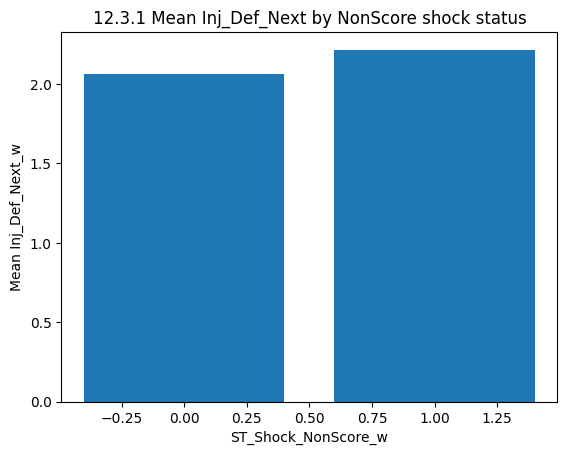

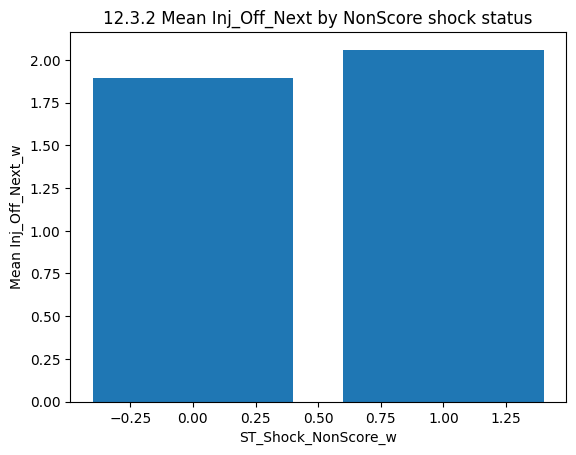

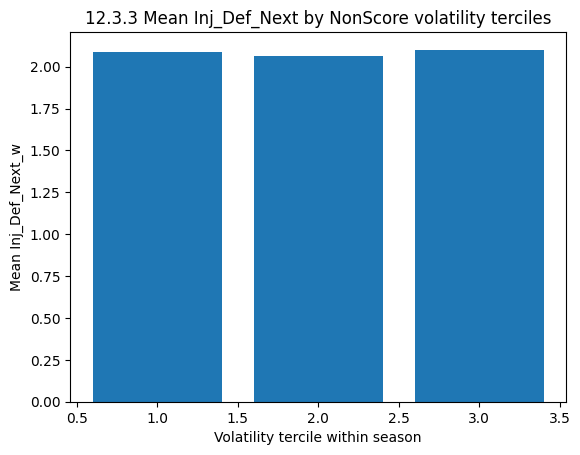

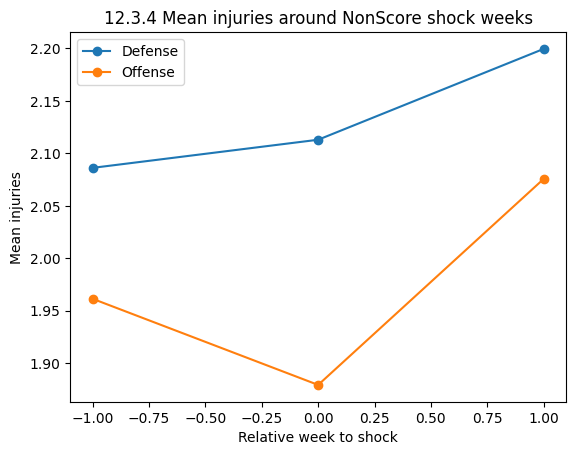

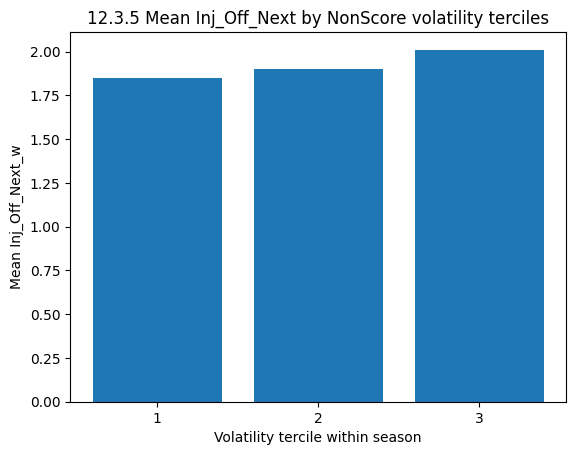

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = df_bar_shock["shock_nonscore"].astype(int).tolist()
y = df_bar_shock["mean_inj_def_next"].astype(float).tolist()
ax.bar(x, y)
ax.set_title("12.3.1 Mean Inj_Def_Next by NonScore shock status")
ax.set_xlabel("ST_Shock_NonScore_w")
ax.set_ylabel("Mean Inj_Def_Next_w")
plt.show()
plt.close(fig)

fig = plt.figure()
ax = fig.add_subplot(111)
x = df_bar_shock["shock_nonscore"].astype(int).tolist()
y = df_bar_shock["mean_inj_off_next"].astype(float).tolist()
ax.bar(x, y)
ax.set_title("12.3.2 Mean Inj_Off_Next by NonScore shock status")
ax.set_xlabel("ST_Shock_NonScore_w")
ax.set_ylabel("Mean Inj_Off_Next_w")
plt.show()
plt.close(fig)

fig = plt.figure()
ax = fig.add_subplot(111)
x = df_bar_tercile["vol_tercile"].astype(int).tolist()
y = df_bar_tercile["mean_inj_def_next"].astype(float).tolist()
ax.bar(x, y)
ax.set_title("12.3.3 Mean Inj_Def_Next by NonScore volatility terciles")
ax.set_xlabel("Volatility tercile within season")
ax.set_ylabel("Mean Inj_Def_Next_w")
plt.show()
plt.close(fig)

fig = plt.figure()
ax = fig.add_subplot(111)
x = df_event["rel_week"].astype(int).tolist()
y1 = df_event["mean_inj_def_next"].astype(float).tolist()
y2 = df_event["mean_inj_off_next"].astype(float).tolist()
ax.plot(x, y1, marker="o", label="Defense")
ax.plot(x, y2, marker="o", label="Offense")
ax.set_title("12.3.4 Mean injuries around NonScore shock weeks")
ax.set_xlabel("Relative week to shock")
ax.set_ylabel("Mean injuries")
ax.legend()
plt.show()
plt.close(fig)

fig = plt.figure()
ax = fig.add_subplot(111)
x = df_bar_tercile["vol_tercile"].astype(int).tolist()
y = df_bar_tercile["mean_inj_off_next"].astype(float).tolist()
ax.bar(x, y)
ax.set_title("12.3.5 Mean Inj_Off_Next by NonScore volatility terciles")
ax.set_xlabel("Volatility tercile within season")
ax.set_ylabel("Mean Inj_Off_Next_w")
ax.set_xticks([1, 2, 3])
plt.show()
plt.close(fig)